# response-level.ipynb
## Author: Elliot Pallister

Notebook for response-level analysis in the Pareto project

In [1]:
# Collecting necessary imports

# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Internal imports
from pareto.data_io import get_cache, get_session, get_unit_channels, get_spike_times, get_stimulus_presentations, get_units_by_area, get_trials
from pareto.preprocessing import make_psth_cube
from pareto.stats import visual_selectivity_filter, subtract_baseline, zscore, roc_analysis
from pareto.plotting import plot_pop_mean, mean_variance_scatter

/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Importing the cache from AllenSDK
cache = get_cache()

# Using session ID 1044385384
session_id = 1044385384
session = get_session(session_id)

units = get_unit_channels(session)
trials = get_trials(session)
stimulus_presentations = get_stimulus_presentations(session)
spike_times = get_spike_times(session)

/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Firstly, I want to filter my units based on:

1. Quality metrics (SNR, interspike interval violations and firing rate)
2. Area (starting with VISp)

In [3]:
quality_unit_filter = ((units['snr'] >= 1) & (units['isi_violations'] < 1) & (units['firing_rate'] > 0.1))
quality_units = units.loc[quality_unit_filter].copy()

area_of_interest = ['VISp']
area_units = get_units_by_area(quality_units, area_of_interest)

print(f'Number of filtered units in {area_of_interest}: {area_units.shape[0]}')


Number of filtered units in ['VISp']: 84


Next, I want to find the stimulus onsets for the image with id: im036_r.

I will use these onsets to:

1. Statistically test the unit responses for selectivity to the image, calculating effect sizes and p values, using a Wilcoxon paired rank test
2. Update the area units dataframe to contain effect sizes and p values in a column
3. Filter the area units by selectivity for the stimulus

In [4]:
stim_of_interest = 'im036_r'
stim_onsets = stimulus_presentations[stimulus_presentations['image_name'] == stim_of_interest]['start_time'].values

# Define the time before the image and the duration of the window during which spikes are counts
time_before_stim = 0.25
duration = 0.5

# Statistical testing
selectivity_mask, effects, p_values = visual_selectivity_filter(area_units, spike_times, stim_onsets, time_before_stim, duration)

area_units = area_units.copy()

# Assigning effect size and p_values
area_units.loc[:, 'p_values'] = p_values
area_units.loc[:, 'effect_size'] = effects

visual_area_units = area_units[selectivity_mask]

print(f'Number of units selective for {stim_of_interest} in {area_of_interest}: {visual_area_units.shape[0]}')

Number of units selective for im036_r in ['VISp']: 54


Next I want to produce a cube of dimensions U x O x T where U is the unit, O is the onset time and T is the time bin (50ms) within a set window around stimulus onset

In [5]:
pre_onset_post_end = (0.25, 0, 0.25, 0.5)

cube, unit_ids, bins = make_psth_cube(visual_area_units, spike_times, stim_onsets, pre_onset_post_end, bin_size=0.01)
bins = bins[:-1]

print(isinstance(cube, np.ndarray))
print(cube.ndim)
print(cube.shape)

True
3
(54, 1064, 75)


Now that I have all of the individual data points, I will begin by baseline subtracting and z-scoring each of these traces and extract some information out by plotting a few important parameters. Here are the following questions I am looking to answer:

1. What is the distribution of mean firing rate taken across all stimulus presentations across all units?
2. What is the variance of firing rate and what is the distribution of this across the population?

[ 0 25]


Text(0.5, 1.0, 'Ranked variance across units')

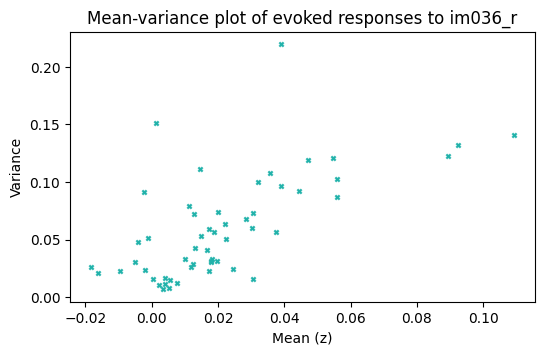

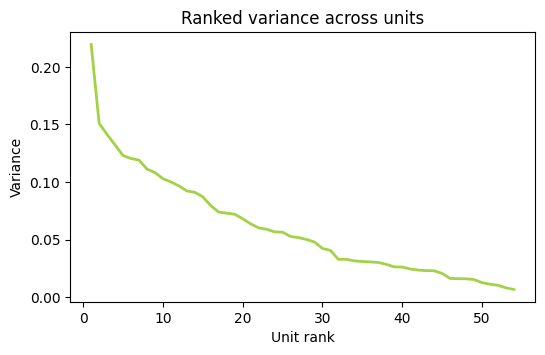

In [ ]:
baseline_window = [-0.25, 0]
baseline_window = np.array(baseline_window)

bsub = subtract_baseline(cube, baseline_window, bins)

zs, mu, std = zscore(bsub)
mu = np.squeeze(mu)
std = np.squeeze(std)

evoked_window = np.array([0, 0.25])
evoked_indices = np.searchsorted(bins, evoked_window)
means = mu[:, evoked_indices[0]:evoked_indices[1]].mean(axis=1)
variances = std[:, evoked_indices[0]:evoked_indices[1]].mean(axis=1) ** 2

fig, ax = plt.subplots(figsize=(6, 3.5))

ax.scatter(means, variances, s=15, c='lightseagreen', marker='X', linewidths=0.2)
ax.set_xlabel("Mean (z)")
ax.set_ylabel("Variance")
ax.set_title("Mean-variance plot of evoked responses to im036_r")

order_variances = np.argsort(variances)[::-1]
ranked_variances = variances[order_variances]
order_means = np.argsort(means)[::-1]
ranked_means = means[order_means]

x = np.arange(1, ranked_variances.size + 1)

fig1, ax1 = plt.subplots(figsize=(6, 3.5))
ax1.plot(x, ranked_variances, lw=2, alpha=0.9, color='yellowgreen')
ax1.set_xlabel("Unit rank")
ax1.set_ylabel("Variance")
ax1.set_title("Ranked variance across units")

 

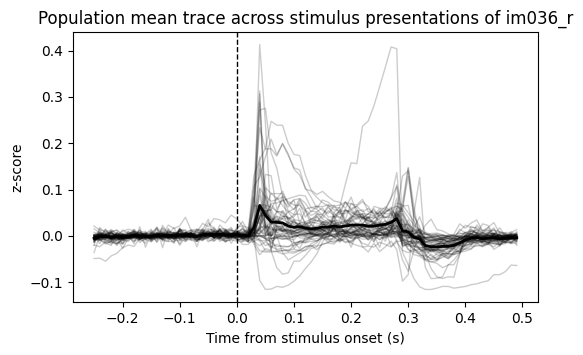

In [7]:
fig1, ax1 = plot_pop_mean(mu, bins)

Next, I will perform an ROC analysis on the evoked responses of the first unit to repeated presentations of im036_r. 

Here I am going to do the following:

1. Obtain a evoked response vector, and split it into non-overlapping chunks of 20
2. Visualise a sample ROC curve for the first and second chunks 

The Area Under Curve (AUC) is 0.54
range(0, 53)


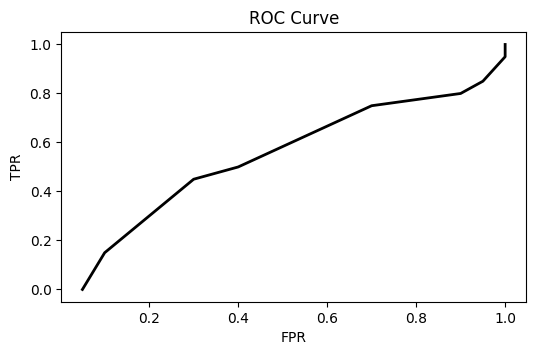

In [16]:
first_unit_responses = bsub[0,:,evoked_indices[0]:evoked_indices[1]].mean(axis=1)

chunk_size = 20
n_chunks = int(round(first_unit_responses.shape[0] / chunk_size))

chunks = []

for i in range(n_chunks):
  chunk = first_unit_responses[i*chunk_size:(i+1)*chunk_size]
  chunks.append(chunk)

TPR, FPR = roc_analysis(chunks[0], chunks[1])

fig, ax = plt.subplots(figsize=(6, 3.5))

ax.plot(FPR, TPR, color='k', lw=2)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC Curve")

order = np.argsort(FPR)
auc = np.trapz(TPR[order], FPR[order])

print(f'The Area Under Curve (AUC) is {auc}')
print(range(n_chunks))


Now I want to look at how this is distributed for each of the chunks compared to the first, plotting each of them and the mean ROC curve.

Text(0.5, 1.0, 'AUC vs. chunk index (Compared to first)')

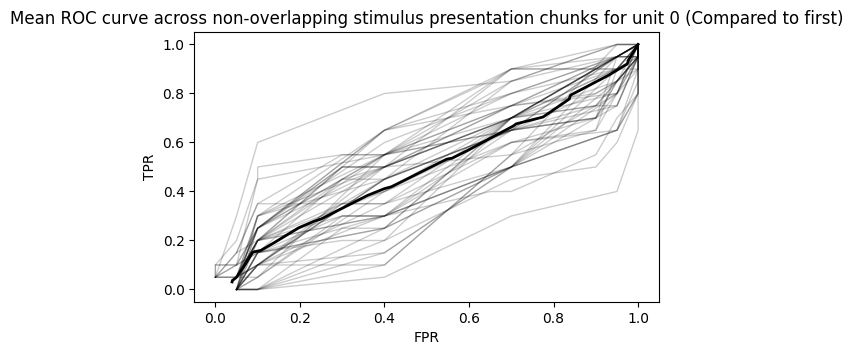

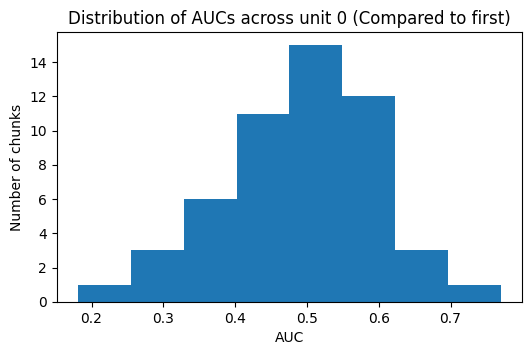

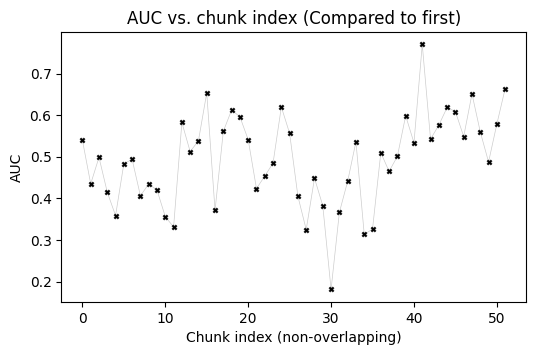

In [30]:
TPRs, FPRs, AUCs = [], [], []

for c in range(n_chunks-1):
  TPR, FPR = roc_analysis(chunks[0], chunks[c+1])
  TPR, FPR = np.array(TPR), np.array(FPR)
  TPRs.append(TPR)
  FPRs.append(FPR)
  order = np.argsort(FPR)
  auc = np.trapz(TPR[order], FPR[order])  
  AUCs.append(auc)

TPRs, FPRs, AUCs = np.array(TPRs), np.array(FPRs), np.array(AUCs)

fig, ax = plt.subplots(figsize=(6, 3.5))

for TPR, FPR in zip(TPRs, FPRs):
  ax.plot(FPR, TPR, color='k', alpha=0.2, lw=1.0, zorder=1)

FPR_mean = FPRs.mean(axis=0)
TPR_mean = TPRs.mean(axis=0)
ax.plot(FPR_mean, TPR_mean, color='k', lw=2.0, zorder=2)

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("Mean ROC curve across non-overlapping stimulus presentation chunks for unit 0 (Compared to first)")

fig1, ax1 = plt.subplots(figsize=(6, 3.5))

ax1.hist(AUCs, bins='fd')
ax1.set_xlabel("AUC")
ax1.set_ylabel("Number of chunks")
ax1.set_title("Distribution of AUCs across unit 0 (Compared to first)")

chunk_indices = list(range(n_chunks-1))
chunk_indices = np.array(chunk_indices)

fig, ax = plt.subplots(figsize=(6, 3.5))

ax.scatter(chunk_indices, AUCs, s=15, c='k', marker='X', linewidths=0.2, zorder=2)
ax.plot(chunk_indices, AUCs, color='k', alpha=0.2, lw=0.5, zorder=1)
ax.set_xlabel("Chunk index (non-overlapping)")
ax.set_ylabel("AUC")
ax.set_title("AUC vs. chunk index (Compared to first)")


Now I will compare on consecutive chunks

Text(0.5, 1.0, 'AUC vs. chunk index (compared to previous chunk)')

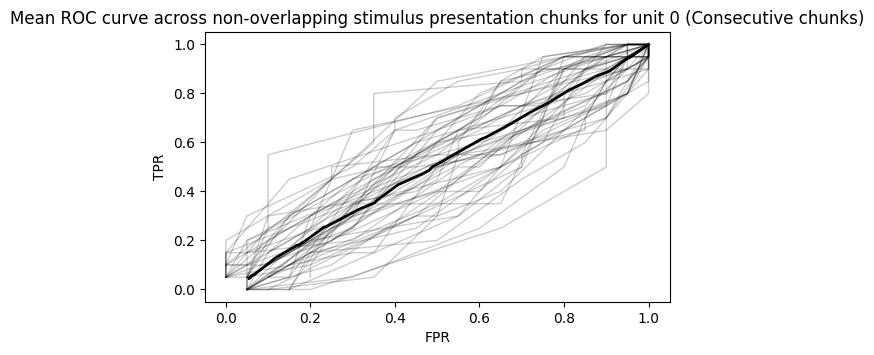

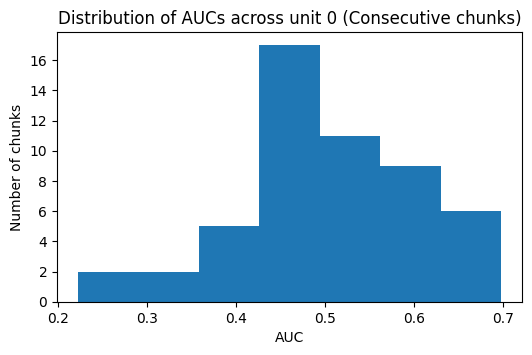

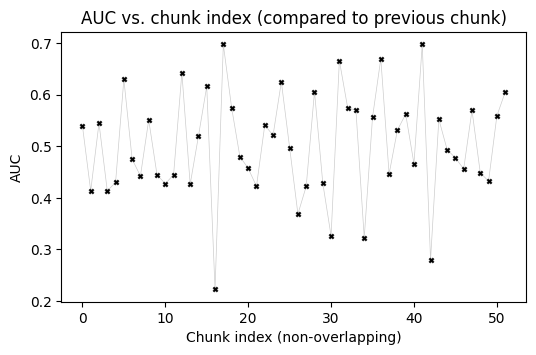

In [29]:

TPRs, FPRs, AUCs = [], [], []

for c in range(n_chunks-1):
  TPR, FPR = roc_analysis(chunks[c], chunks[c+1])
  TPR, FPR = np.array(TPR), np.array(FPR)
  TPRs.append(TPR)
  FPRs.append(FPR)
  order = np.argsort(FPR)
  auc = np.trapz(TPR[order], FPR[order])  
  AUCs.append(auc)

TPRs, FPRs, AUCs = np.array(TPRs), np.array(FPRs), np.array(AUCs)

fig, ax = plt.subplots(figsize=(6, 3.5))

for TPR, FPR in zip(TPRs, FPRs):
  ax.plot(FPR, TPR, color='k', alpha=0.2, lw=1.0, zorder=1)

FPR_mean = FPRs.mean(axis=0)
TPR_mean = TPRs.mean(axis=0)
ax.plot(FPR_mean, TPR_mean, color='k', lw=2.0, zorder=2)

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("Mean ROC curve across non-overlapping stimulus presentation chunks for unit 0 (Consecutive chunks)")

fig1, ax1 = plt.subplots(figsize=(6, 3.5))

ax1.hist(AUCs, bins='fd')
ax1.set_xlabel("AUC")
ax1.set_ylabel("Number of chunks")
ax1.set_title("Distribution of AUCs across unit 0 (Consecutive chunks)")

chunk_indices = list(range(n_chunks-1))
chunk_indices = np.array(chunk_indices)

fig, ax = plt.subplots(figsize=(6, 3.5))

ax.scatter(chunk_indices, AUCs, s=15, c='k', marker='X', linewidths=0.2, zorder=2)
ax.plot(chunk_indices, AUCs, color='k', alpha=0.2, lw=0.5, zorder=1)
ax.set_xlabel("Chunk index (non-overlapping)")
ax.set_ylabel("AUC")
ax.set_title("AUC vs. chunk index (compared to previous chunk)")